In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from colorama import Fore, Back, Style
from math import sin, cos, sqrt, atan2
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', -1)

#from sklearn import 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


### Function needed

In [4]:
### Function needed

def drop_virgule(x):
    try:return x.split('.')[0]
    except:return x

def processing(df):
    df.drop(columns=columns_to_drop,inplace=True)
    df['Listing ID']=df['Listing ID'].apply(drop_virgule)              # Drop the '.0' in Listing ID
    df['Host ID']=df['Host ID'].apply(drop_virgule)
    df['Postal Code']=df['Postal Code'].apply(drop_virgule)
    df['Host Since']=pd.to_datetime(df['Host Since'])                  # Convert values to datetime
    df['First Review']=pd.to_datetime(df['First Review'])
    df['Last Review']=pd.to_datetime(df['Last Review'])
    df['Accomodates'].replace('*', np.nan,inplace=True)                 # Put NaN in missing values
    df['Bathrooms'].replace('*', np.nan,inplace=True)
    df['Bedrooms'].replace('*', np.nan,inplace=True)
    df['Beds'].replace('*', np.nan,inplace=True)
    df['Guests Included'].replace('*', np.nan,inplace=True)
    df['Min Nights'].replace('*', np.nan,inplace=True)

    df['Accomodates'] = df['Accomodates'].astype('float')              # Convert values to float
    df['Bathrooms'] = df['Bathrooms'].astype('float')
    df['Bedrooms'] = df['Bedrooms'].astype('float')
    df['Beds'] = df['Beds'].astype('float')
    df['Guests Included'] = df['Guests Included'].astype('float')
    df['Min Nights'] = df['Min Nights'].astype('float') 
    df.columns = df.columns.str.lower().str.replace(' ','_')           # Rename the columns with '_' instead of ' '
    return df
    
def missing(df,detail=False):
    total = 0
    for col in df.columns:
        miss = df[col].isnull().sum()
        pct = df[col].isna().mean() * 100
        total += miss
        if miss != 0:
            if pct>10: color=Fore.RED
            else: color=Fore.YELLOW
            print(color+'{} => {} [{}%]'.format(col, miss, round(pct, 2)))
        
        elif (total == 0) and(detail):
            print(Fore.GREEN+'{} => no missing values [{}%]'.format(col, 0))
        total=0
        
def distance(lat1,lon1,lat2,lon2):
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def KNN(listings,neighbors,on=['postal_code','',''],how='weighted_average'):
    for i,row in listings.iterrows():
        candidates=neighbors[on+['latitude','longitude','price']].copy()
        for i in range(0,len(on)):
            candidates=candidates[candidates[on[i]]==row[on[i]]]


### Importing and exploring the data

In [5]:
path='/Users/aminelarhchim/Documents/3A/ML/Projet ML/Datasets/train_airbnb_berlin.csv'
my_sep,my_encoding=',','utf-8'
columns_to_drop=['Listing Name','Host Name','City','Country Code','Country']
types={'Listing ID':'str','Host ID':'str','Postal Code':'str'}

data=pd.read_csv(path,sep=my_sep,encoding=my_encoding,dtype=types)

In [6]:
df=processing(data)

In [7]:
missing(df)

listing_id => 1 [0.01%]
host_since => 21 [0.13%]
host_response_time => 7075 [45.09%]
host_response_rate => 7075 [45.09%]
is_superhost => 23 [0.15%]
postal_code => 229 [1.46%]
accomodates => 19 [0.12%]
bathrooms => 25 [0.16%]
bedrooms => 16 [0.1%]
beds => 20 [0.13%]
square_feet => 15389 [98.07%]
guests_included => 10 [0.06%]
min_nights => 249 [1.59%]
first_review => 2705 [17.24%]
last_review => 2706 [17.24%]
overall_rating => 2962 [18.88%]
accuracy_rating => 2971 [18.93%]
cleanliness_rating => 2970 [18.93%]
checkin_rating => 2973 [18.95%]
communication_rating => 2970 [18.93%]
location_rating => 2971 [18.93%]
value_rating => 2972 [18.94%]
price => 9 [0.06%]


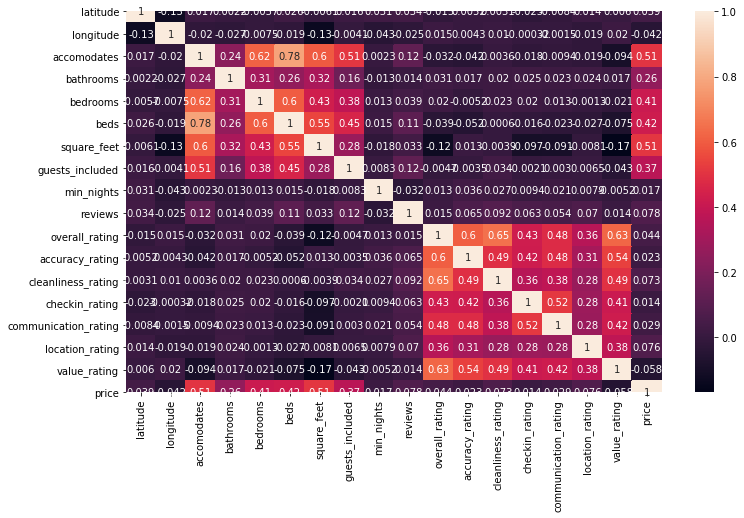

In [75]:
corrMatrices = df.corr()
plt.figure(figsize = (12,7))
sns.heatmap(corrMatrices, annot=True)

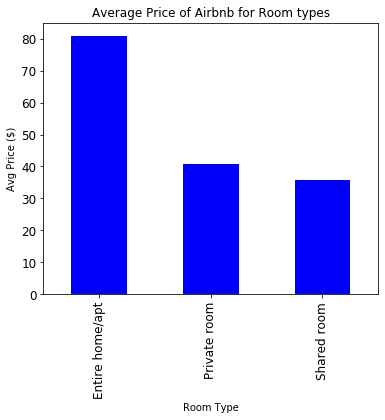

In [83]:
# Plotting the average price by room type
avg_price_roomtype= df.groupby(['room_type'])['price'].agg(np.mean)
avg_price_roomtype.plot(kind='bar', color='blue', figsize = (6,5), fontsize = 12)
plt.title('Average Price of Airbnb for Room types')
plt.xlabel('Room Type')
plt.ylabel('Avg Price ($)')
plt.show()


In [79]:
# Checking the price 
df['price'].describe()

count    15683.000000
mean     60.342983   
std      48.829687   
min      8.000000    
25%      32.000000   
50%      49.000000   
75%      70.000000   
max      900.000000  
Name: price, dtype: float64

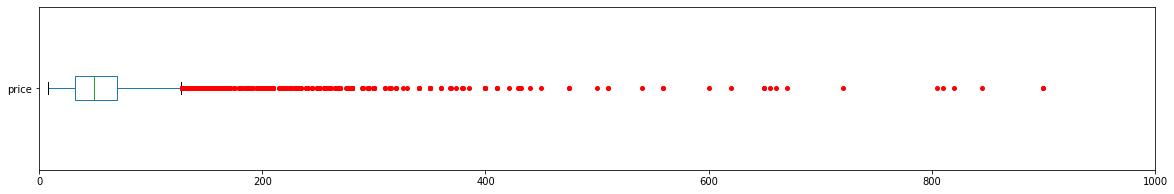

In [80]:

flierprops = dict(marker='.', markerfacecolor='r', markersize=8,
                  linestyle='none', markeredgecolor='r')
df['price'].plot(kind='box', xlim = (0 , 1000), vert=False, figsize = (20,3) , flierprops = flierprops )

 We see that 75% of prices are below 70 euros and that the outliers fade out after 300

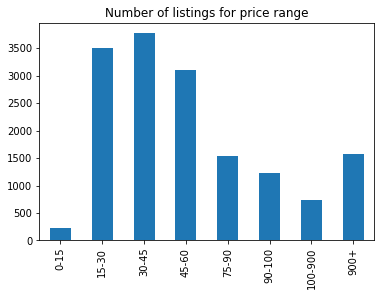

In [88]:
# Creating price range column
price_range = pd.cut(df['price'], 
                     bins=[0, 15, 30, 45, 60, 75, 90, 100, df["price"].max()], 
                     labels=["0-15", "15-30", "30-45", "45-60", "75-90", "90-100", "100-"+str(int(df.price.max())), str(int(df.price.max()))+'+'])
df['price_range'] = price_range 
df['price_range'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of listings for price range')
plt.show()

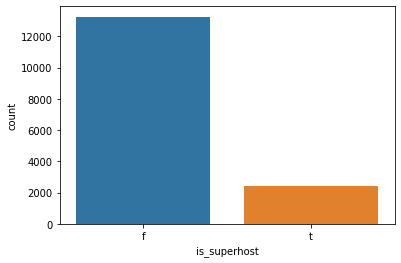

In [91]:
sns.countplot(x='is_superhost', data = df)

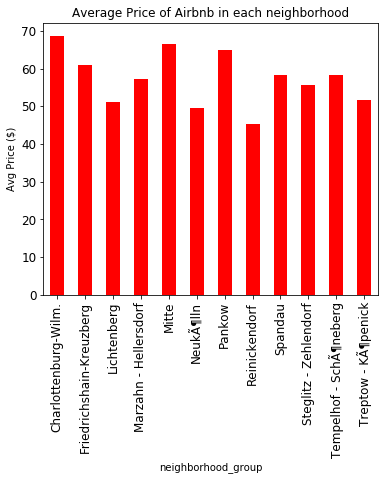

In [94]:
# Plotting the average price neighborhood_group
avg_price_roomtype= df.groupby(['neighborhood_group'])['price'].agg(np.mean)
avg_price_roomtype.plot(kind='bar', color='red', figsize = (6,5), fontsize = 12)
plt.title('Average Price of Airbnb in each neighborhood')
plt.xlabel('neighborhood_group')
plt.ylabel('Avg Price ($)')
plt.show()


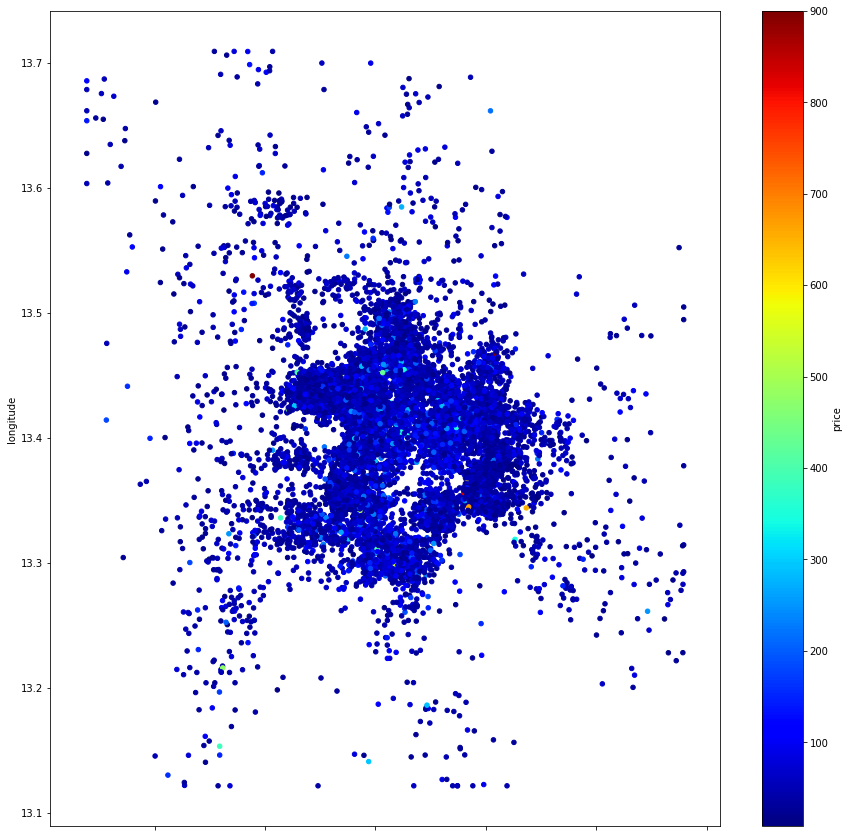

In [10]:
df.plot.scatter(x='latitude',y='longitude',figsize=(15,15),c='price',cmap='jet')

Idées
Créer une feature pour la distance au centre
Pour les features qui sont des dates : mettre une nouvelle feature avec juste l'année de la first_review 
Remplir square_feet avec la moyenne  de la taille d'un appart pour le district ou avec un imputer

### Testing models

In [8]:
df.drop(columns=['host_id','listing_id','host_since','first_review','last_review'],inplace=True)

In [9]:
### Preprocessing

X=df.drop(columns=['price'])
y=df['price'].copy()

numerical_columns = X.select_dtypes(exclude=object).columns
categorical_columns = X.select_dtypes(include=object).columns

In [10]:

num_pipeline = Pipeline([
    ('missing', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])

In [12]:
housing_data_transformer = ColumnTransformer([
    ("num", num_pipeline, numerical_columns),
    ("cat", LabelEncoder(), categorical_columns)
])

In [14]:
# # Splitting data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
def train_test_linear_regressor(X_train, y_train, X_test, y_test):
    '''Trains and test a linear regression model on the given training and test set.
    The function prints the RMSE of the predictions on the test set.
    
    Parameters
    ----------
        X_train : {array-like, sparse matrix}
            The matrix with the values of the features of the training instances.
        y_train : array-like
            The vector  with the values of the target variable of the training instances.
        X_test : {array-like, sparse matrix}
            The matrix with the values of the features of the test instances.
        y_test : array-like
            The vector  with the values of the target variable of the test instances.
            
    '''
    
    ##################### COMPLETE THE CODE HERE #####################

    # Define the full pipeline, with data processing and the estimator (a SGDRegressor)
    full_pipeline = Pipeline([
            ("data_processing", housing_data_transformer),
            ("linear_regression", LinearRegression())
        ])

    # Transform the training data and train the linear regressor.
    full_pipeline.fit(X_train, y_train)

    # Test the linear regressor on the test data.
    predictions = full_pipeline.predict(X_test)

    # Compute the prediction error.
    mse = mean_squared_error(y_test, predictions)
    
    # Print the RMSE.
    print(np.sqrt(mse))
    
    ###############################################################
    
train_test_linear_regressor(X_train, y_train, X_test, y_test)

NameError: name 'LinearRegression' is not defined

In [104]:
# one-hot encoding of categorical features

cat_features=df[categorical_columns]
num_features=df[numerical_columns]

le=LabelEncoder()
sc=StandardScaler()

for col in cat_features.columns:
    cat_features[col]=le.fit_transform(cat_features[col])
    
num_features=sc.fit_transform(num_features)



X = pd.concat([num_features, cat_features], axis=1)

TypeError: argument must be a string or number

In [93]:
# # Splitting data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [94]:
## Scaling and encoding the variables
le = LabelEncoder()
sc=StandardScaler()

preprocessor = ColumnTransformer([('label_encoder', le, categorical_columns),
                                  ('standard_scaler', sc, numerical_columns)])



In [18]:
data['host_since']

KeyError: 'host_since'